In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torchvision.models import VisionTransformer
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [3]:
!pip install timm 
import timm
from timm.loss import LabelSmoothingCrossEntropy

In [4]:
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import time
import copy

In [5]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [6]:
def get_data_loaders(data_dir, batch_size):
    # Train
    train_transform = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        T.RandomErasing(p=0.2, value='random')
    ])
    train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = train_transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # Val
    val_transform = T.Compose([ # We dont need augmentation for test transforms
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
    ])
    val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=val_transform)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)

    return train_loader, val_loader, len(train_data), len(val_data)


In [7]:
def get_test_loader(data_dir, batch_size):
    test_transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
    ])
    test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=test_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)

    return test_loader, len(test_data)

In [8]:
dataset_path = "/kaggle/input/butterfly-images40-species"

In [9]:
train_loader, val_loader, train_data_len, val_data_len = get_data_loaders(dataset_path, 32)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
test_loader, test_data_len = get_test_loader('/kaggle/input/butterfly-images40-species', 32)

In [11]:
classes = get_classes("/kaggle/input/butterfly-images40-species/train")
print(classes, len(classes))

['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BANDED TIGER MOTH', 'BECKERS WHITE', 'BIRD CHERRY ERMINE MOTH', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CINNABAR MOTH', 'CLEARWING MOTH', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMET MOTH', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'EMPEROR GUM MOTH', 'GARDEN TIGER MOTH', 'GIANT LEOPARD MOTH', 'GLITTERING SAPPHIRE', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREEN HAIRSTREAK', 'GREY HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'INDRA SWALLOW', 'IO MOTH', 'Iphiclus si

In [12]:
print(len(classes))
print(train_data_len)

100
12594


In [13]:
dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader  # add the test loader here
}

dataset_sizes = {
    "train": train_data_len,
    "val": val_data_len,
    "test": test_data_len  # add the test dataset size here
}

In [14]:
print(len(train_loader), len(val_loader),len(test_loader))

394 16 16


In [15]:
print(train_data_len, val_data_len, test_data_len)

12594 500 500


In [16]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import DeiTModel, DeiTConfig
from transformers import AutoFeatureExtractor
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

model_name = 'facebook/deit-base-distilled-patch16-224'

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [18]:


class DeiTr(nn.Module):
    def __init__(self, num_labels=100):
        super(DeiTr, self).__init__()
        self.deitr = DeiTModel.from_pretrained(model_name, add_pooling_layer=False)
        
        # Adjust hidden size to match SwinModel output size
        hidden_size = self.deitr.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, x): 
        """This method defines the forward pass of the module. It takes a batch of input images x as input and passes them through the Swin Transformer model to get the embeddings of all tokens in the input. 
        It then uses the embedding of the [CLS] token as the representation of the entire input sequence and passes it through the linear classifier to predict the output labels."""
        x = self.deitr(x)['last_hidden_state']
        # Use the embedding of [CLS] token
        output = self.classifier(x[:, 0, :])
        return output


In [19]:
def model_train(dataset, epochs, learning_rate, bs):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load model, loss function, and optimizer
    model = DeiTr().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Load batch image
    train_loader, val_loader, train_data_len, val_data_len = get_data_loaders(dataset, batch_size=bs)

    train_losses = []
    val_losses = []
    
    # Fine-tuning loop
    for i in range(epochs):
        total_acc_train = 0
        total_loss_train = 0.0

        # Training loop
        model.train()
        for train_image, train_label in tqdm(train_loader):
            output = model(train_image.to(device))
            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Store the training loss for this epoch
        train_losses.append(total_loss_train / train_data_len)

        # Validation loop
        model.eval()
        total_acc_val = 0
        total_loss_val = 0.0
        with torch.no_grad():
            for val_image, val_label in val_loader:
                output = model(val_image.to(device))
                loss = criterion(output, val_label.to(device))
                acc = (output.argmax(dim=1) == val_label.to(device)).sum().item()
                total_acc_val += acc
                total_loss_val += loss.item()

        # Store the validation loss for this epoch
        val_losses.append(total_loss_val / val_data_len)

        print(f'Epoch: {i + 1} | Train Loss: {total_loss_train / train_data_len:.3f} | Train Accuracy: {total_acc_train / train_data_len:.3f}')
        print(f'Epoch: {i + 1} | Val Loss: {total_loss_val / val_data_len:.3f} | Val Accuracy: {total_acc_val / val_data_len:.3f}')

    return model, train_losses, val_losses


In [20]:
EPOCHS = 30
LEARNING_RATE = 1e-4
BATCH_SIZE = 16

# Train the model
trained_model, train_losses, val_losses = model_train('/kaggle/input/butterfly-images40-species', EPOCHS, LEARNING_RATE, BATCH_SIZE)

Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTModel: ['cls_classifier.weight', 'cls_classifier.bias', 'distillation_classifier.bias', 'distillation_classifier.weight']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker cr

Epoch: 1 | Train Loss: 0.042 | Train Accuracy: 0.842
Epoch: 1 | Val Loss: 0.015 | Val Accuracy: 0.922


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 2 | Train Loss: 0.012 | Train Accuracy: 0.947
Epoch: 2 | Val Loss: 0.016 | Val Accuracy: 0.938


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 3 | Train Loss: 0.008 | Train Accuracy: 0.962
Epoch: 3 | Val Loss: 0.013 | Val Accuracy: 0.946


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 4 | Train Loss: 0.006 | Train Accuracy: 0.971
Epoch: 4 | Val Loss: 0.011 | Val Accuracy: 0.958


100%|██████████| 788/788 [06:57<00:00,  1.89it/s]


Epoch: 5 | Train Loss: 0.005 | Train Accuracy: 0.973
Epoch: 5 | Val Loss: 0.014 | Val Accuracy: 0.950


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 6 | Train Loss: 0.005 | Train Accuracy: 0.977
Epoch: 6 | Val Loss: 0.021 | Val Accuracy: 0.934


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 7 | Train Loss: 0.005 | Train Accuracy: 0.979
Epoch: 7 | Val Loss: 0.013 | Val Accuracy: 0.952


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 8 | Train Loss: 0.004 | Train Accuracy: 0.980
Epoch: 8 | Val Loss: 0.013 | Val Accuracy: 0.948


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 9 | Train Loss: 0.003 | Train Accuracy: 0.985
Epoch: 9 | Val Loss: 0.013 | Val Accuracy: 0.950


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 10 | Train Loss: 0.004 | Train Accuracy: 0.984
Epoch: 10 | Val Loss: 0.013 | Val Accuracy: 0.962


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 11 | Train Loss: 0.003 | Train Accuracy: 0.984
Epoch: 11 | Val Loss: 0.014 | Val Accuracy: 0.950


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 12 | Train Loss: 0.003 | Train Accuracy: 0.988
Epoch: 12 | Val Loss: 0.013 | Val Accuracy: 0.956


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 13 | Train Loss: 0.003 | Train Accuracy: 0.985
Epoch: 13 | Val Loss: 0.015 | Val Accuracy: 0.950


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 14 | Train Loss: 0.003 | Train Accuracy: 0.986
Epoch: 14 | Val Loss: 0.015 | Val Accuracy: 0.956


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 15 | Train Loss: 0.002 | Train Accuracy: 0.990
Epoch: 15 | Val Loss: 0.015 | Val Accuracy: 0.962


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 16 | Train Loss: 0.003 | Train Accuracy: 0.987
Epoch: 16 | Val Loss: 0.014 | Val Accuracy: 0.958


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 17 | Train Loss: 0.002 | Train Accuracy: 0.990
Epoch: 17 | Val Loss: 0.018 | Val Accuracy: 0.936


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 18 | Train Loss: 0.003 | Train Accuracy: 0.988
Epoch: 18 | Val Loss: 0.012 | Val Accuracy: 0.964


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 19 | Train Loss: 0.002 | Train Accuracy: 0.990
Epoch: 19 | Val Loss: 0.016 | Val Accuracy: 0.956


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 20 | Train Loss: 0.002 | Train Accuracy: 0.990
Epoch: 20 | Val Loss: 0.018 | Val Accuracy: 0.942


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 21 | Train Loss: 0.003 | Train Accuracy: 0.989
Epoch: 21 | Val Loss: 0.014 | Val Accuracy: 0.952


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 22 | Train Loss: 0.002 | Train Accuracy: 0.990
Epoch: 22 | Val Loss: 0.014 | Val Accuracy: 0.962


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 23 | Train Loss: 0.002 | Train Accuracy: 0.991
Epoch: 23 | Val Loss: 0.015 | Val Accuracy: 0.960


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 24 | Train Loss: 0.002 | Train Accuracy: 0.989
Epoch: 24 | Val Loss: 0.017 | Val Accuracy: 0.954


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 25 | Train Loss: 0.002 | Train Accuracy: 0.989
Epoch: 25 | Val Loss: 0.016 | Val Accuracy: 0.952


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 26 | Train Loss: 0.002 | Train Accuracy: 0.992
Epoch: 26 | Val Loss: 0.024 | Val Accuracy: 0.948


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 27 | Train Loss: 0.003 | Train Accuracy: 0.988
Epoch: 27 | Val Loss: 0.015 | Val Accuracy: 0.960


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 28 | Train Loss: 0.002 | Train Accuracy: 0.992
Epoch: 28 | Val Loss: 0.016 | Val Accuracy: 0.960


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 29 | Train Loss: 0.002 | Train Accuracy: 0.992
Epoch: 29 | Val Loss: 0.016 | Val Accuracy: 0.958


100%|██████████| 788/788 [06:58<00:00,  1.88it/s]


Epoch: 30 | Train Loss: 0.002 | Train Accuracy: 0.991
Epoch: 30 | Val Loss: 0.019 | Val Accuracy: 0.942


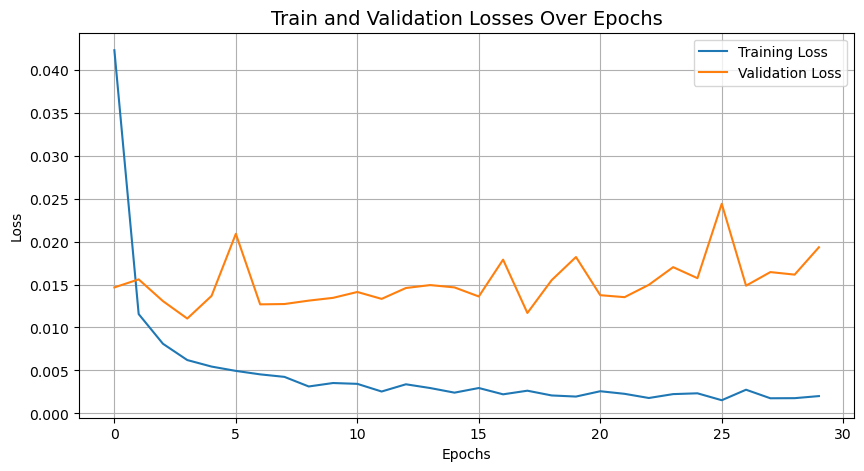

In [21]:
# Plotting the training and validation loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [25]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [26]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    top_5_correct = 0
    criterion = nn.CrossEntropyLoss().to(device)

    with torch.no_grad():  # Disable gradient tracking
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
            total += labels.size(0)  # Update the total number of samples
            correct += (predicted == labels).sum().item()  # Update the number of correct predictions
            
            # For top-5 accuracy
            top_5_values, top_5_predicted = torch.topk(outputs.data, 5)
            for i in range(len(labels)):
                if labels[i] in top_5_predicted[i]:
                    top_5_correct += 1

        loss = criterion(outputs, labels)

    accuracy = correct / total  # Calculate the accuracy
    top_5_accuracy = top_5_correct / total
    return loss, accuracy, top_5_accuracy


test_loss, test_accuracy, test_top_5_accuracy = evaluate_model(trained_model, test_loader, device)
print(f"Test loss: {round(test_loss.item(), 2)}")
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(test_top_5_accuracy * 100, 2)}%")



Test loss: 0.2
Test accuracy: 96.2%
Test top 5 accuracy: 99.6%
